In [1]:
#import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import csv
#import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
#import json
import time 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from dataloader import get_loader


In [2]:
class CNN1D(nn.Module):
    #gives window wise prediction. No correlation with other windows considered
    def __init__(self, nchns=128):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(nchns, 96, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(96, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
       
        
        self.bn1 = nn.BatchNorm1d(96)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(384)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn5 = nn.BatchNorm1d(256)

        
        self.drop2 = nn.Dropout(p=0.2)
        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(36*256, 1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 4)
        
    def forward(self, x):

        x = F.max_pool1d(self.bn1(F.leaky_relu((self.conv1(x)) )), 2)
        #x = self.drop1(x)
        
        x = F.max_pool1d(self.bn2(F.leaky_relu((self.conv2(x)) )), 2)
        #x = self.drop1(x)
       
        x = F.max_pool1d(self.bn3(F.leaky_relu((self.conv3(x)) )), 2)
        #x = self.drop1(x)
        
        x = F.max_pool1d(self.bn4(F.leaky_relu((self.conv4(x)) )), 2)
        #x = self.drop1(x)
        
        x = F.max_pool1d(self.bn5(F.leaky_relu((self.conv5(x)) )), 2)
        #x = self.drop1(x)
        
        x = x.view(-1, 36*256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [3]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        target = y[:, 1]
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                        epoch, batch_idx * len(data), len(train_loader.dataset),
                                        100. * batch_idx / len(train_loader), loss.item()))
        epoch_loss += loss.item()
        train_losses.append(loss.item())
        train_counter.append(
                            (batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
    epoch_losses.append(epoch_loss)
        #torch.save(model.state_dict(), '/results/model.pth')
        #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [4]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, y in test_loader:
            output = model(data)
            target = y[:, 1]
            test_loss += F.nll_loss(output, target, size_average=False, reduction='mean').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                        test_loss, correct, len(test_loader.dataset),
                        100. * correct / len(test_loader.dataset)))

In [5]:
root = '/home/deeksha/Documents/MLSP/derivatives/'
creater = get_loader(root)
batch_size=100
train_loader = creater([1, 2, 3, 4, 5, 6, 7], batch_size=batch_size)
test_loader = creater([8], batch_size=1)

In [6]:
model = CNN1D()
model = model.double()

n_epochs = 25
lr= 1e-3

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)
optimizer = optim.Adam(model.parameters(), lr = lr)

In [7]:
train_losses = []
train_counter = []
test_losses = []
epoch_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

log_interval = 1

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/deeksha/anaconda3/envs/deepai/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3871, Accuracy: 40/160 (25%)

Train Epoch: 1 [0/1080 (0%)]	Loss: 1.388096
Train Epoch: 1 [100/1080 (9%)]	Loss: 1.845382
Train Epoch: 1 [200/1080 (18%)]	Loss: 1.467543
Train Epoch: 1 [300/1080 (27%)]	Loss: 1.396257
Train Epoch: 1 [400/1080 (36%)]	Loss: 1.465989
Train Epoch: 1 [500/1080 (45%)]	Loss: 1.427442
Train Epoch: 1 [600/1080 (55%)]	Loss: 1.386732
Train Epoch: 1 [700/1080 (64%)]	Loss: 1.377231
Train Epoch: 1 [800/1080 (73%)]	Loss: 1.399582
Train Epoch: 1 [900/1080 (82%)]	Loss: 1.480436
Train Epoch: 1 [800/1080 (91%)]	Loss: 1.431741

Test set: Avg. loss: 1.3959, Accuracy: 40/160 (25%)

Train Epoch: 2 [0/1080 (0%)]	Loss: 1.275454
Train Epoch: 2 [100/1080 (9%)]	Loss: 1.301356
Train Epoch: 2 [200/1080 (18%)]	Loss: 1.361621
Train Epoch: 2 [300/1080 (27%)]	Loss: 1.294300
Train Epoch: 2 [400/1080 (36%)]	Loss: 1.278473
Train Epoch: 2 [500/1080 (45%)]	Loss: 1.222362
Train Epoch: 2 [600/1080 (55%)]	Loss: 1.255136
Train Epoch: 2 [700/1080 (64%)]	Loss: 1.300380
Train E

Text(0, 0.5, 'negative log likelihood loss')

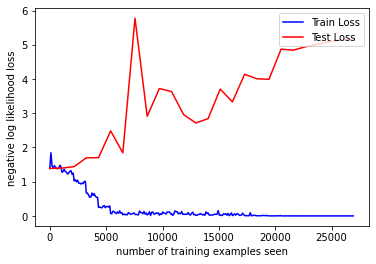

In [8]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


In [9]:
epoch_losses = np.array(epoch_losses) / len(train_loader)

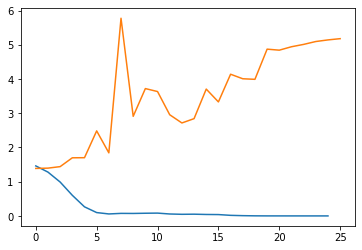

In [10]:
plt.plot(epoch_losses)
plt.plot(test_losses)

In [13]:
correct = 0
for i, (data, y) in enumerate(train_loader):
        output = model(data)
        target = y[:, 1]
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        
print(100. * correct / len(train_loader.dataset))

tensor(100.)
